In [ ]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.9 MB 4.1 MB/s 


In [ ]:
import itertools
import re
import nltk

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter



from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

import nltk.corpus
from nltk import tokenize
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
data = pd.read_excel("Fake_News_Data.xlsx")
data.head()

,LABEL,STATEMENT,SUBJECT,SPEAKER,JOB_TITLE,STATE,PARTY_AFFILIATION,Context/Venue/Location,BARELY_TRUE,False,HALF_TRUE,MOSTLY_TRUE,PANTS_FIRE
0,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,0.0,1.0,0.0,0.0,0.0
1,0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,0.0,0.0,1.0,1.0,0.0
2,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver,70.0,71.0,160.0,163.0,9.0
3,0,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,a news release,7.0,19.0,3.0,5.0,44.0
4,0,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN,15.0,9.0,20.0,19.0,2.0


# **Data Preprocessing**

In [ ]:
data.dtypes

LABEL                       int64
STATEMENT                  object
SUBJECT                    object
SPEAKER                    object
JOB_TITLE                  object
STATE                      object
PARTY_AFFILIATION          object
Context/Venue/Location     object
BARELY_TRUE               float64
False                     float64
HALF_TRUE                 float64
MOSTLY_TRUE               float64
PANTS_FIRE                float64
dtype: object

In [ ]:
data.count()

LABEL                     10240
STATEMENT                 10240
SUBJECT                   10238
SPEAKER                   10238
JOB_TITLE                  7343
STATE                      8032
PARTY_AFFILIATION         10238
Context/Venue/Location    10138
BARELY_TRUE               10238
False                     10238
HALF_TRUE                 10238
MOSTLY_TRUE               10238
PANTS_FIRE                10238
dtype: int64

## **Missing Values**

In [ ]:
data.isnull().any()

LABEL                     False
STATEMENT                 False
SUBJECT                    True
SPEAKER                    True
JOB_TITLE                  True
STATE                      True
PARTY_AFFILIATION          True
Context/Venue/Location     True
BARELY_TRUE                True
False                      True
HALF_TRUE                  True
MOSTLY_TRUE                True
PANTS_FIRE                 True
dtype: bool

In [ ]:
data.isnull().sum()

LABEL                        0
STATEMENT                    0
SUBJECT                      2
SPEAKER                      2
JOB_TITLE                 2897
STATE                     2208
PARTY_AFFILIATION            2
Context/Venue/Location     102
BARELY_TRUE                  2
False                        2
HALF_TRUE                    2
MOSTLY_TRUE                  2
PANTS_FIRE                   2
dtype: int64

In [ ]:
data = data.drop(data.loc[data['Context/Venue/Location'].isnull()].index)

In [ ]:
data = data.drop(data.loc[data['JOB_TITLE'].isnull()].index)

In [ ]:
data = data.drop(data.loc[data['STATE'].isnull()].index)

In [ ]:
data.isnull().any()

LABEL                     False
STATEMENT                 False
SUBJECT                   False
SPEAKER                   False
JOB_TITLE                 False
STATE                     False
PARTY_AFFILIATION         False
Context/Venue/Location    False
BARELY_TRUE               False
False                     False
HALF_TRUE                 False
MOSTLY_TRUE               False
PANTS_FIRE                False
dtype: bool

In [ ]:
data.count()

LABEL                     6724
STATEMENT                 6724
SUBJECT                   6724
SPEAKER                   6724
JOB_TITLE                 6724
STATE                     6724
PARTY_AFFILIATION         6724
Context/Venue/Location    6724
BARELY_TRUE               6724
False                     6724
HALF_TRUE                 6724
MOSTLY_TRUE               6724
PANTS_FIRE                6724
dtype: int64

## **Converting Categorical Variables to Numerical**

### **SUBJECT**



In [ ]:
data["SUBJECT"].value_counts()

health-care                                                                                       263
taxes                                                                                             211
immigration                                                                                       177
elections                                                                                         171
education                                                                                         147
                                                                                                 ... 
bankruptcy,candidates-biography,history,income,campaign-advertising,taxes,wealth                    1
bipartisanship,elections,redistricting                                                              1
congress,corporations,deficit,economy,federal-budget,financial-regulation,foreign-policy,taxes      1
congress,federal-budget,history                                                   

In [ ]:
data["SUBJECT"].unique()

array(['abortion', 'energy,history,job-accomplishments', 'foreign-policy',
       ..., 'bipartisanship,immigration', 'food',
       'gays-and-lesbians,polls,supreme-court'], dtype=object)

In [ ]:
ord_enc = OrdinalEncoder()
data["subject"] = ord_enc.fit_transform(data[["SUBJECT"]])
data[["SUBJECT", "subject"]].head(84)

,SUBJECT,subject
0,abortion,16.0
1,"energy,history,job-accomplishments",1792.0
2,foreign-policy,2001.0
5,education,1620.0
7,ethics,1850.0
...,...,...
112,"elections,taxes",1754.0
113,jobs,2411.0
114,"economy,jobs",1525.0
116,"civil-rights,gays-and-lesbians,states",746.0


### **SPEAKER**

In [ ]:
data["SPEAKER"].value_counts()

barack-obama         481
donald-trump         273
hillary-clinton      235
mitt-romney          174
scott-walker         149
                    ... 
deval-patrick          1
joshua-marquis         1
donna-garner           1
kurt-browning          1
kathleen-sullivan      1
Name: SPEAKER, Length: 1635, dtype: int64

In [ ]:
data["SPEAKER"].unique()

array(['dwayne-bohac', 'scott-surovell', 'barack-obama', ...,
       'dennis-ross', 'christine-whitman', 'john-rafferty'], dtype=object)

In [ ]:
ord_enc = OrdinalEncoder()
data["speaker"] = ord_enc.fit_transform(data[["SPEAKER"]])
data[["SPEAKER", "speaker"]].head(84)

,SPEAKER,speaker
0,dwayne-bohac,438.0
1,scott-surovell,1404.0
2,barack-obama,80.0
5,robin-vos,1335.0
7,barack-obama,80.0
...,...,...
112,donna-brazile,413.0
113,paul-ryan,1205.0
114,barack-obama,80.0
116,mark-pocan,1014.0


### **JOB_TITLE**

In [ ]:
data["JOB_TITLE"].value_counts()

President                                                                          485
U.S. Senator                                                                       472
Governor                                                                           383
President-Elect                                                                    273
U.S. senator                                                                       252
                                                                                  ... 
Policy analyst ACLU                                                                  1
director, Grand Jury/Intake Division, Travis County  District Attorney's office      1
Chief Justice of the United States                                                   1
Wilson Center CEO                                                                    1
Pundit and communications consultant                                                 1
Name: JOB_TITLE, Length: 997, dtype: int64

In [ ]:
data["JOB_TITLE"].unique()

array(['State representative', 'State delegate', 'President',
       'Wisconsin Assembly speaker', 'U.S. Senator', 'Former governor',
       'Columnist', 'U.S. House member -- 1th District',
       'Treasury secretary ', 'state representative',
       'Presidential candidate', 'Advocacy group',
       'House Minority Leader', 'musician',
       'President of American Freedom Defense Intitiative',
       'Lieutenant governor', 'State senator',
       'U.S. House of Representative', 'Governor',
       'U.S. House of Representatives', 'Senator', 'Austin mayor',
       'state land commissioner',
       'Speaker of the House of Representatives', 'Attorney General',
       'State agriculture commissioner', 'Senate Candidate',
       'Senior Vice President, Government Affairs, Georgia Chamber of Commerce',
       'President-Elect', 'U.S. senator', 'Attorney', 'Talk-show host',
       'president, ceo of Apartments for America, Inc.',
       'Former state Senator', 'U.S. solicitor general',
   

In [ ]:
ord_enc = OrdinalEncoder()
data["job-title"] = ord_enc.fit_transform(data[["JOB_TITLE"]])
data[["JOB_TITLE", "job-title"]].head(84)

,JOB_TITLE,job-title
0,State representative,711.0
1,State delegate,709.0
2,President,527.0
5,Wisconsin Assembly speaker,808.0
7,President,527.0
...,...,...
112,Political commentator,517.0
113,U.S. Representative,761.0
114,President,527.0
116,"State Assembly member, 78th District",673.0


### **STATE**

In [ ]:
data["STATE"].value_counts()

Texas              938
New York           635
Florida            601
Wisconsin          557
Illinois           537
                  ... 
China                1
Tex                  1
Russia               1
ohio                 1
Washington D.C.      1
Name: STATE, Length: 77, dtype: int64

In [ ]:
data["STATE"].unique()

array(['Texas', 'Virginia', 'Illinois', 'Wisconsin', 'New Jersey',
       'Vermont', 'Massachusetts', 'Maryland', 'Washington, D.C. ',
       'Oregon', 'New York', 'Washington, D.C.', 'California', 'Missouri',
       'Rhode Island', 'West Virginia', 'Florida', 'Arkansas',
       'New Hampshire', 'Ohio', 'Georgia', 'Arizona', 'Wyoming',
       'Delaware', 'Kentucky', 'Kansas', 'ohio', 'North Carolina',
       'New Mexico', 'Illinois ', 'South Carolina', 'Minnesota',
       'Tennessee', 'Iowa', 'Connecticut', 'Louisiana', 'Indiana',
       'Florida ', 'Colorado', 'Utah', 'Pennsylvania', 'Michigan',
       'Oklahoma', 'Nevada', 'Virgina', 'Nebraska', 'Georgia ', 'None',
       'Massachusetts ', 'Russia', 'Washington state', 'Washington',
       'District of Columbia', 'Alaska', 'Unknown', 'Mississippi',
       'Alabama', 'China', 'United Kingdom', 'Virginia ', 'Colorado ',
       'South Dakota', 'Qatar', 'North Dakota', 'Idaho', 'Maine',
       'New York ', 'Virginia director, Coalition t

In [ ]:
ord_enc = OrdinalEncoder()
data["state"] = ord_enc.fit_transform(data[["STATE"]])
data[["STATE", "state"]].head(84)

,STATE,state
0,Texas,56.0
1,Virginia,63.0
2,Illinois,18.0
5,Wisconsin,73.0
7,Illinois,18.0
...,...,...
112,"Washington, D.C.",70.0
113,Wisconsin,73.0
114,Illinois,18.0
116,Wisconsin,73.0


### **PARTY_AFFILIATION**

In [ ]:
data["PARTY_AFFILIATION"].value_counts()

republican                      3394
democrat                        2614
none                             369
independent                      125
newsmaker                         34
libertarian                       31
columnist                         29
activist                          26
journalist                        23
organization                      23
talk-show-host                    15
state-official                    14
labor-leader                      10
business-leader                    6
tea-party-member                   4
green                              3
constitution-party                 1
ocean-state-tea-party-action       1
education-official                 1
democratic-farmer-labor            1
Name: PARTY_AFFILIATION, dtype: int64

In [ ]:
data["PARTY_AFFILIATION"].unique()

array(['republican', 'democrat', 'independent', 'columnist', 'none',
       'activist', 'talk-show-host', 'libertarian', 'newsmaker',
       'organization', 'labor-leader', 'state-official', 'journalist',
       'education-official', 'business-leader', 'tea-party-member',
       'green', 'democratic-farmer-labor', 'ocean-state-tea-party-action',
       'constitution-party'], dtype=object)

In [ ]:
ord_enc = OrdinalEncoder()
data["party"] = ord_enc.fit_transform(data[["PARTY_AFFILIATION"]])
data[["PARTY_AFFILIATION", "party"]].head(84)

,PARTY_AFFILIATION,party
0,republican,16.0
1,democrat,4.0
2,democrat,4.0
5,republican,16.0
7,democrat,4.0
...,...,...
112,democrat,4.0
113,republican,16.0
114,democrat,4.0
116,democrat,4.0


### **Context/Venue/Location**

In [ ]:
data["Context/Venue/Location"].value_counts()

a speech                                                168
an interview                                            161
a press release                                         136
a news release                                          128
a tweet                                                 115
                                                       ... 
legal filings                                             1
an interview on CBS's Face the Nation                     1
an Austin City Council meeting about the city budget      1
in an interview on "This Week."                           1
a speech to the American Legion                           1
Name: Context/Venue/Location, Length: 3083, dtype: int64

In [ ]:
data["Context/Venue/Location"].unique()

array(['a mailer', 'a floor speech.', 'Denver', ...,
       'an op-ed in the Tampa Bay Times',
       'a press gaggle aboard Air Force One.', 'an interview on NJTV'],
      dtype=object)

In [ ]:
ord_enc = OrdinalEncoder()
data["context"] = ord_enc.fit_transform(data[["Context/Venue/Location"]])
data[["Context/Venue/Location", "context"]].head(84)

,Context/Venue/Location,context
0,a mailer,940.0
1,a floor speech.,818.0
2,Denver,56.0
5,a an online opinion-piece,518.0
7,"a Democratic debate in Philadelphia, Pa.",252.0
...,...,...
112,"comments on CNN's ""State of the Union""",2535.0
113,a vice presidential debate,1711.0
114,the State of the Union address,3021.0
116,a statement,1563.0


## **Removing Categorical Variables form data as we have their Numerical Form**

In [ ]:
data.head()

,LABEL,STATEMENT,SUBJECT,SPEAKER,JOB_TITLE,STATE,PARTY_AFFILIATION,Context/Venue/Location,BARELY_TRUE,False,HALF_TRUE,MOSTLY_TRUE,PANTS_FIRE,subject,speaker,job-title,state,party,context
0,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,0.0,1.0,0.0,0.0,0.0,16.0,438.0,711.0,56.0,16.0,940.0
1,0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,0.0,0.0,1.0,1.0,0.0,1792.0,1404.0,709.0,63.0,4.0,818.0
2,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver,70.0,71.0,160.0,163.0,9.0,2001.0,80.0,527.0,18.0,4.0,56.0
5,1,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,a an online opinion-piece,0.0,3.0,2.0,5.0,1.0,1620.0,1335.0,808.0,73.0,16.0,518.0
7,0,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,"a Democratic debate in Philadelphia, Pa.",70.0,71.0,160.0,163.0,9.0,1850.0,80.0,527.0,18.0,4.0,252.0


In [ ]:
data=data.drop(columns=['SUBJECT','SPEAKER','JOB_TITLE','STATE','PARTY_AFFILIATION','Context/Venue/Location'])

In [ ]:
data.head()

,LABEL,STATEMENT,BARELY_TRUE,False,HALF_TRUE,MOSTLY_TRUE,PANTS_FIRE,subject,speaker,job-title,state,party,context
0,0,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0,16.0,438.0,711.0,56.0,16.0,940.0
1,0,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0,1792.0,1404.0,709.0,63.0,4.0,818.0
2,1,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0,2001.0,80.0,527.0,18.0,4.0,56.0
5,1,The Chicago Bears have had more starting quart...,0.0,3.0,2.0,5.0,1.0,1620.0,1335.0,808.0,73.0,16.0,518.0
7,0,I'm the only person on this stage who has work...,70.0,71.0,160.0,163.0,9.0,1850.0,80.0,527.0,18.0,4.0,252.0


# **Data Analysis**

In [ ]:
data.groupby(['LABEL']).size()

LABEL
0    4207
1    2517
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


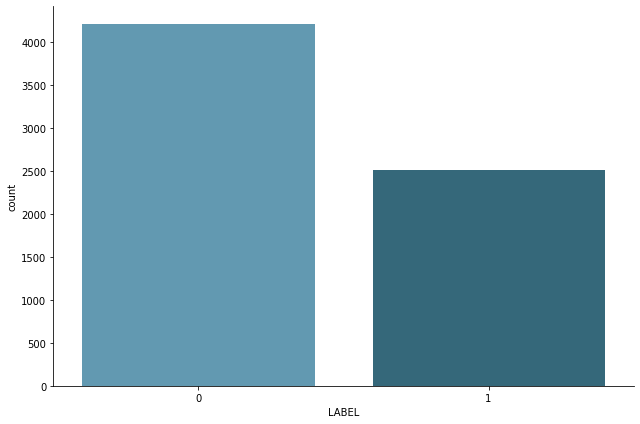

In [ ]:
sns.factorplot(x="LABEL", data=data, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


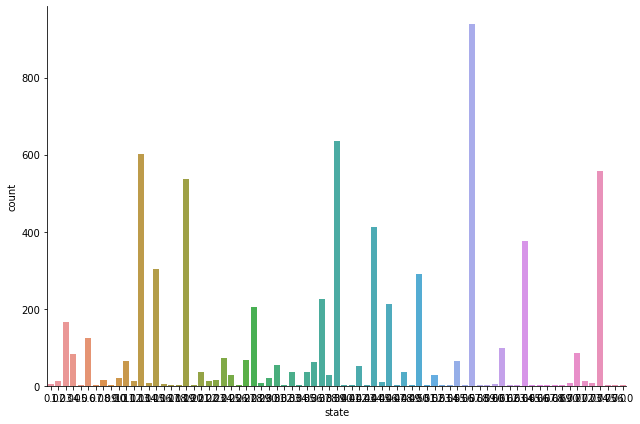

In [ ]:
sns.factorplot(x="state", data=data, kind="count", size=6, aspect=1.5)
plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


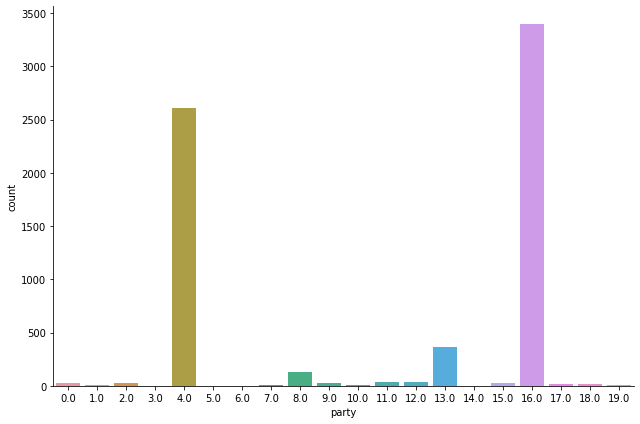

In [ ]:
sns.factorplot(x="party", data=data, kind="count", size=6, aspect=1.5)
plt.show();

In [ ]:
unique_speakers = data['speaker'].nunique()
avg_statments = len(data) / unique_speakers

print(f"Unique speakers in dataset: {unique_speakers}")
print(f"Average statements made per speaker: {avg_statments}")

Unique speakers in dataset: 1635
Average statements made per speaker: 4.112538226299694


In [ ]:
corr_matrix=data.corr()
corr_matrix

,LABEL,BARELY_TRUE,False,HALF_TRUE,MOSTLY_TRUE,PANTS_FIRE,subject,speaker,job-title,state,party,context
LABEL,1.000000,-0.015849,-0.056095,0.040844,0.064671,-0.113994,-0.015474,-0.049644,0.044358,-0.022698,-0.137876,-0.001905
BARELY_TRUE,-0.015849,1.000000,0.930567,0.908245,0.875729,0.654306,0.054555,-0.290284,-0.029509,-0.258147,-0.047245,0.038871
False,-0.056095,0.930567,1.000000,0.752059,0.703182,0.851666,0.056621,-0.277370,-0.039798,-0.194111,0.057119,0.042937
HALF_TRUE,0.040844,0.908245,0.752059,1.000000,0.987056,0.350242,0.044999,-0.363753,-0.055340,-0.294847,-0.229074,0.020540
MOSTLY_TRUE,0.064671,0.875729,0.703182,0.987056,1.000000,0.261183,0.038697,-0.386564,-0.013530,-0.284318,-0.279570,0.017270
PANTS_FIRE,-0.113994,0.654306,0.851666,0.350242,0.261183,1.000000,0.043970,-0.125231,-0.076787,-0.065323,0.240876,0.050186
subject,-0.015474,0.054555,0.056621,0.044999,0.038697,0.043970,1.000000,-0.000168,-0.010920,-0.072063,0.071818,-0.019000
speaker,-0.049644,-0.290284,-0.277370,-0.363753,-0.386564,-0.125231,-0.000168,1.000000,-0.080047,0.185316,0.254636,-0.007406
job-title,0.044358,-0.029509,-0.039798,-0.055340,-0.013530,-0.076787,-0.010920,-0.080047,1.000000,-0.034740,-0.114517,0.000079
state,-0.022698,-0.258147,-0.194111,-0.294847,-0.284318,-0.065323,-0.072063,0.185316,-0.034740,1.000000,0.033166,-0.012694


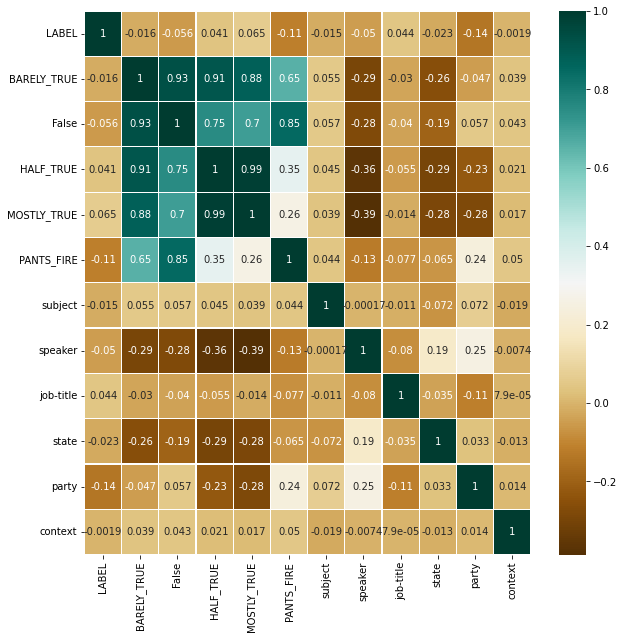

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data = corr_matrix, cmap='BrBG', annot=True, linewidth=0.2)

## **Statement Analysis**

In [ ]:
data['number_of_words'] = data.STATEMENT.apply(lambda x: len(x.split()))
data.head()

,LABEL,STATEMENT,BARELY_TRUE,False,HALF_TRUE,MOSTLY_TRUE,PANTS_FIRE,subject,speaker,job-title,state,party,context,number_of_words
0,0,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0,16.0,438.0,711.0,56.0,16.0,940.0,11
1,0,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0,1792.0,1404.0,709.0,63.0,4.0,818.0,24
2,1,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0,2001.0,80.0,527.0,18.0,4.0,56.0,19
5,1,The Chicago Bears have had more starting quart...,0.0,3.0,2.0,5.0,1.0,1620.0,1335.0,808.0,73.0,16.0,518.0,27
7,0,I'm the only person on this stage who has work...,70.0,71.0,160.0,163.0,9.0,1850.0,80.0,527.0,18.0,4.0,252.0,27


In [ ]:
x=data.number_of_words

print('Descriptive stats for {}'.format('number_of_words'))
print('-'*(len('number_of_words')+22))
print(data.groupby('LABEL')['number_of_words'].describe())


Descriptive stats for number_of_words
-------------------------------------
        count       mean       std  min   25%   50%   75%    max
LABEL                                                           
0      4207.0  17.922272  9.044451  2.0  12.0  17.0  22.0  309.0
1      2517.0  18.223679  7.667138  3.0  13.0  17.0  22.0   61.0


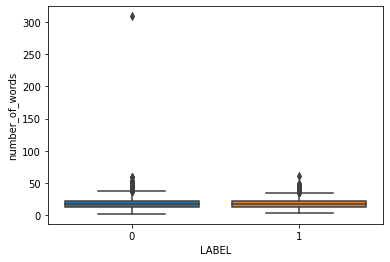

In [ ]:
sns.boxplot(y='number_of_words', x='LABEL', 
                 data=data)

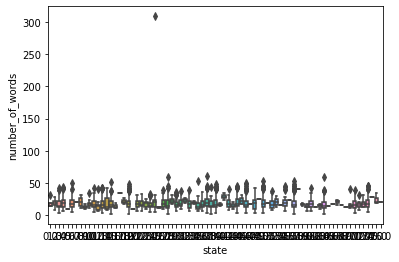

In [ ]:
sns.boxplot(y='number_of_words', x='state', 
                 data=data)

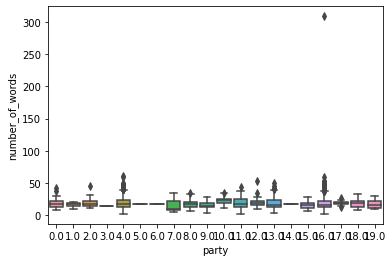

In [ ]:
sns.boxplot(y='number_of_words', x='party', 
                 data=data)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


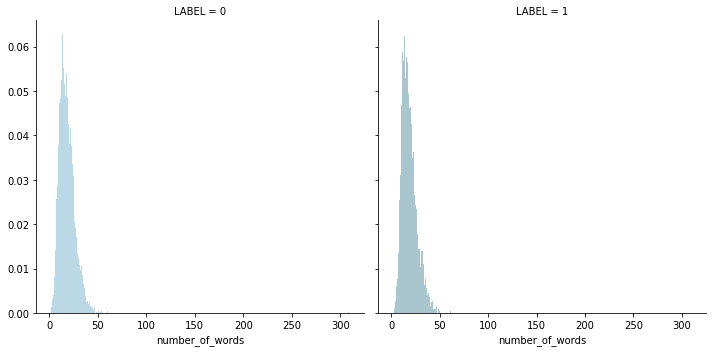

In [ ]:
bins = np.arange(data['number_of_words'].min(), data['number_of_words'].max() + 1)
g = sns.FacetGrid(data, col='LABEL', size=5, hue='LABEL', palette="PuBuGn_d")
g = g.map(sns.distplot, 'number_of_words', kde=False, norm_hist=True, bins=bins)
plt.show()

# **Text Preprocessing**

## **Text Sizing**

In [ ]:
data.drop(data[data['number_of_words'] < 5].index, inplace = True)

In [ ]:
data.drop(data[data['number_of_words'] > 100].index, inplace = True)

In [ ]:
data.head()

,LABEL,STATEMENT,BARELY_TRUE,False,HALF_TRUE,MOSTLY_TRUE,PANTS_FIRE,subject,speaker,job-title,state,party,context,number_of_words
0,0,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0,16.0,438.0,711.0,56.0,16.0,940.0,11
1,0,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0,1792.0,1404.0,709.0,63.0,4.0,818.0,24
2,1,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0,2001.0,80.0,527.0,18.0,4.0,56.0,19
5,1,The Chicago Bears have had more starting quart...,0.0,3.0,2.0,5.0,1.0,1620.0,1335.0,808.0,73.0,16.0,518.0,27
7,0,I'm the only person on this stage who has work...,70.0,71.0,160.0,163.0,9.0,1850.0,80.0,527.0,18.0,4.0,252.0,27


In [ ]:
data.count()

LABEL              6677
STATEMENT          6677
BARELY_TRUE        6677
False              6677
HALF_TRUE          6677
MOSTLY_TRUE        6677
PANTS_FIRE         6677
subject            6677
speaker            6677
job-title          6677
state              6677
party              6677
context            6677
number_of_words    6677
dtype: int64

## **Text Cleaning**

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   
    #characters and then strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
data["text_clean"] = data["STATEMENT"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

data.head()

,LABEL,STATEMENT,BARELY_TRUE,False,HALF_TRUE,MOSTLY_TRUE,PANTS_FIRE,subject,speaker,job-title,state,party,context,number_of_words,text_clean
0,0,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0,16.0,438.0,711.0,56.0,16.0,940.0,11,say annies list political group support thirdt...
1,0,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0,1792.0,1404.0,709.0,63.0,4.0,818.0,24,decline coal start started natural gas took st...
2,1,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0,2001.0,80.0,527.0,18.0,4.0,56.0,19,hillary clinton agrees john mccain voting give...
5,1,The Chicago Bears have had more starting quart...,0.0,3.0,2.0,5.0,1.0,1620.0,1335.0,808.0,73.0,16.0,518.0,27,chicago bear starting quarterback last 00 year...
7,0,I'm the only person on this stage who has work...,70.0,71.0,160.0,163.0,9.0,1850.0,80.0,527.0,18.0,4.0,252.0,27,im person stage worked actively last year pass...


In [ ]:
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

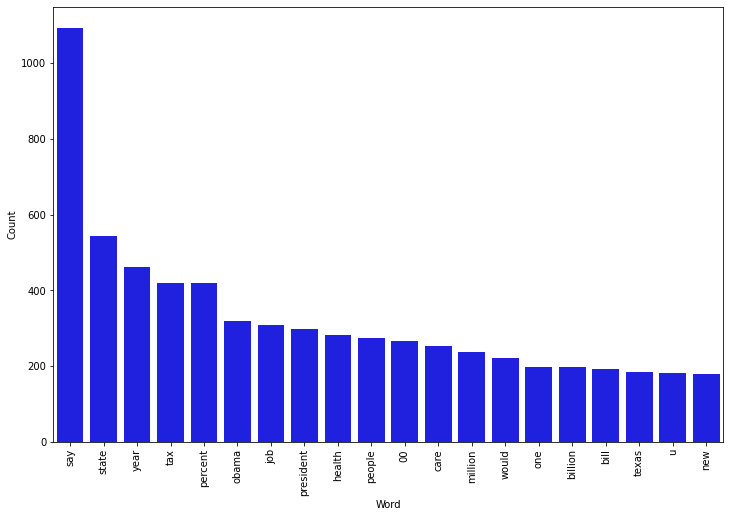

In [ ]:
counter(data[data["LABEL"] == 0], "text_clean", 20)

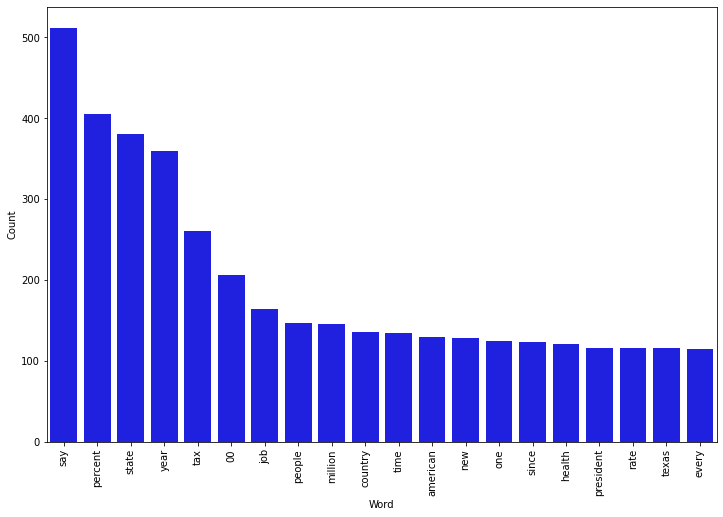

In [ ]:
counter(data[data["LABEL"] == 1], "text_clean", 20)

In [ ]:
data=data.drop(columns=['STATEMENT','number_of_words'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['text_clean'],data['LABEL'], stratify=data['LABEL'])

# **Implementation**

## **Logistic Regression with CountVectorizer**

In [ ]:
cvec = CountVectorizer()


# tokenize, build vocab and encode training data
train_cvec = cvec.fit_transform(X_train.values)

print(cvec.vocabulary_)

{'say': 5975, 'bipartisan': 980, 'support': 6643, 'including': 3485, '10': 177, 'sheriff': 6166, 'throughout': 6878, 'state': 6473, 'democrat': 1966, 'republican': 5718, 'chile': 1358, '70': 263, 'percent': 4998, 'gdp': 2980, 'saving': 5972, 'city': 1394, 'houston': 3367, 'debt': 1877, 'per': 4997, 'caput': 1222, 'california': 1184, 'cant': 1211, 'pas': 4927, 'budget': 1127, 'senate': 6085, 'united': 7157, 'without': 7484, '60': 235, 'vote': 7302, '00': 0, 'oregon': 4768, 'inmate': 3551, 'prison': 5281, 'violent': 7282, 'crime': 1757, 'serious': 6108, 'sex': 6138, 'offense': 4693, 'quadrupled': 5427, 'agent': 497, 'secure': 6056, 'border': 1046, 'last': 3896, 'time': 6895, 'held': 3254, 'hostage': 3357, 'resolution': 5750, 'ensure': 2432, 'country': 1717, 'bill': 973, 'paid': 4874, 'cost': 1697, 'billion': 975, 'added': 431, 'interest': 3604, 'slowed': 6284, 'economic': 2283, 'recovery': 5574, '06': 81, 'trillion': 7018, 'national': 4513, 'would': 7519, 'cover': 1728, 'entire': 2441, '

In [ ]:
print(train_cvec.shape)
print(type(train_cvec))
print(train_cvec.toarray())

(5007, 7580)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
logReg_pipeline_cv = Pipeline([
    ('LogRCV', cvec),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_cv.fit(X_train, y_train)

Pipeline(steps=[('LogRCV', CountVectorizer()),
                ('LogR_model', LogisticRegression())])

In [ ]:
y_predicted = logReg_pipeline_cv.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
accuracy_score(y_test, y_predicted)

0.6107784431137725

In [ ]:
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[806, 237],
       [413, 214]])

Text(33.0, 0.5, 'Truth')

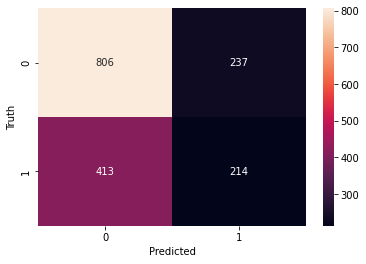

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      1043
           1       0.47      0.34      0.40       627

    accuracy                           0.61      1670
   macro avg       0.57      0.56      0.55      1670
weighted avg       0.59      0.61      0.59      1670



## **Logistic Regression with Td-Idf**

In [ ]:
tfidf_vec = TfidfTransformer()

train_tfidf_vec = tfidf_vec.fit_transform(train_cvec)

In [ ]:
print(train_tfidf_vec.shape)
print(train_tfidf_vec.toarray())

(5007, 7580)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), use_idf=True, smooth_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(X_train.values)

In [ ]:
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0]


# place tf-idf values in a pandas data frame
d = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
d.sort_values(by=["tfidf"],ascending=False)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
10 sheriff,0.309397
including 10,0.309397
state democrat,0.309397
say bipartisan,0.309397
support including,0.309397
...,...
fedex,0.000000
fee,0.000000
fee 000,0.000000
fee able,0.000000


In [ ]:
logReg_pipeline_ngram = Pipeline([
    ('LogR_tfidf', tfidf_vectorizer),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_ngram.fit(X_train, y_train)

Pipeline(steps=[('LogR_tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('LogR_model', LogisticRegression())])

In [ ]:
y_predicted = logReg_pipeline_ngram.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
accuracy_score(y_test, y_predicted)

0.6317365269461078

In [ ]:
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[951,  92],
       [523, 104]])

Text(33.0, 0.5, 'Truth')

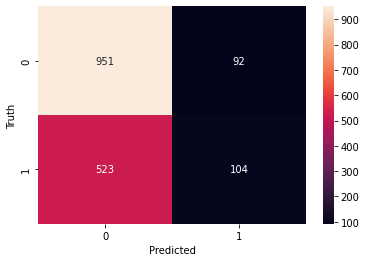

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76      1043
           1       0.53      0.17      0.25       627

    accuracy                           0.63      1670
   macro avg       0.59      0.54      0.50      1670
weighted avg       0.60      0.63      0.57      1670



## **Neural Network with BERT**

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),  
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
157/157 [==============================] - 2178s 14s/step - loss: 0.6805 - accuracy: 0.6020 - precision: 0.4050 - recall: 0.1282
Epoch 2/5
157/157 [==============================] - 2160s 14s/step - loss: 0.6690 - accuracy: 0.6105 - precision: 0.4098 - recall: 0.0846
Epoch 3/5
157/157 [==============================] - 2145s 14s/step - loss: 0.6725 - accuracy: 0.6064 - precision: 0.4156 - recall: 0.1191
Epoch 4/5
157/157 [==============================] - 2145s 14s/step - loss: 0.6664 - accuracy: 0.6119 - precision: 0.4537 - recall: 0.1644
Epoch 5/5
157/157 [==============================] - 2152s 14s/step - loss: 0.6660 - accuracy: 0.6175 - precision: 0.4689 - recall: 0.1404


In [ ]:
model.evaluate(X_test, y_test)

53/53 [==============================] - 725s 14s/step - loss: 0.6529 - accuracy: 0.6240 - precision: 0.4944 - recall: 0.0702


[0.652854859828949,
 0.6239520907402039,
 0.49438202381134033,
 0.07017543911933899]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[998,  45],
       [583,  44]])

Text(33.0, 0.5, 'Truth')

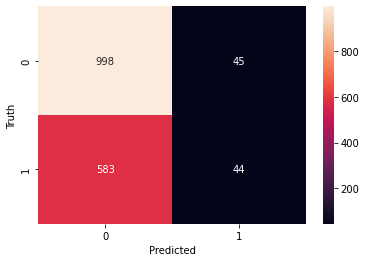

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.63      0.96      0.76      1043
           1       0.49      0.07      0.12       627

    accuracy                           0.62      1670
   macro avg       0.56      0.51      0.44      1670
weighted avg       0.58      0.62      0.52      1670

